In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

# import utils
import sys
sys.path.append('../../../utils')
import calibrate, simulate, misc

In [2]:
df = pd.read_csv("../../../../datasets/TrueFX/EURUSD-2024-02/EURUSD-2024-02.csv", header=None)
df.columns = ['Pair', 'TimeStamp', 'Bid', 'Ask']
df['Timestamp'] = pd.to_datetime(df['TimeStamp']) - pd.Timedelta(hours=5) # turn GMT to EST time
df = df[['Timestamp', 'Bid', 'Ask']]

df['Date'] = df['Timestamp'].dt.date
df['Time'] = df['Timestamp'].dt.time
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second

df['Mid'] = (df['Bid'] + df['Ask']) / 2

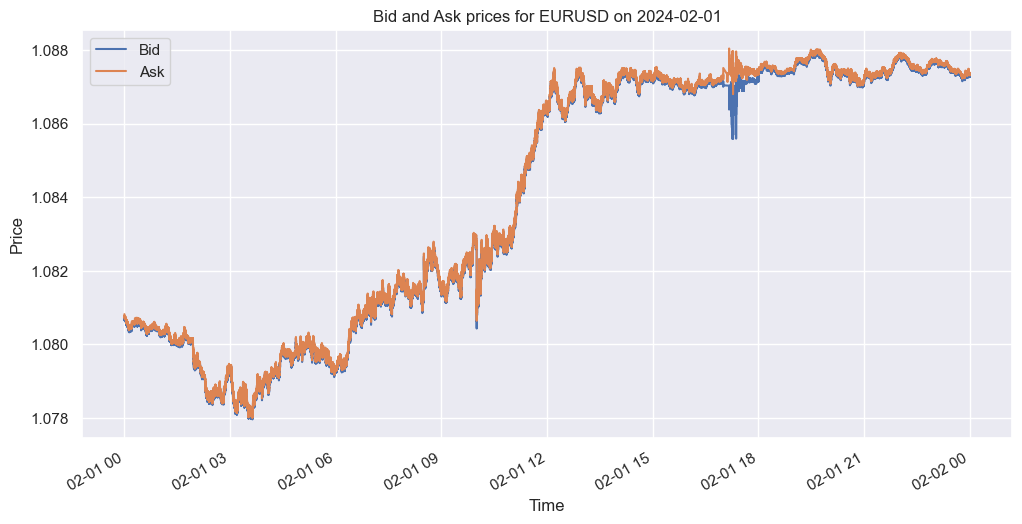

In [3]:
chosen_date = pd.to_datetime('2024-02-01').date()
oneday = df[df['Date'] == chosen_date]
oneday.plot(x='Timestamp', y=['Bid', 'Ask'], xlabel="Time", ylabel="Price", title="Bid and Ask prices for EURUSD on {}".format(chosen_date), figsize=(12, 6))
plt.show()

## wtf is going on with the various hours of the day (see plots below) ??

   # TODO: compare using Mid/Ask/Bid
   # TODO: we should be using log(price) instead of price

c:\Users\gecre\OneDrive\Polytechnique\MAP\MAP565 - Processes\projet_lombric\src\notebooks\clean\FX\../../../utils\misc.py:38: RuntimeWarning: overflow encountered in exp
  return Lambda*(kappa**2 + (1 - kappa**2) * (1 - np.exp(-gamma * x)) / (gamma * x))


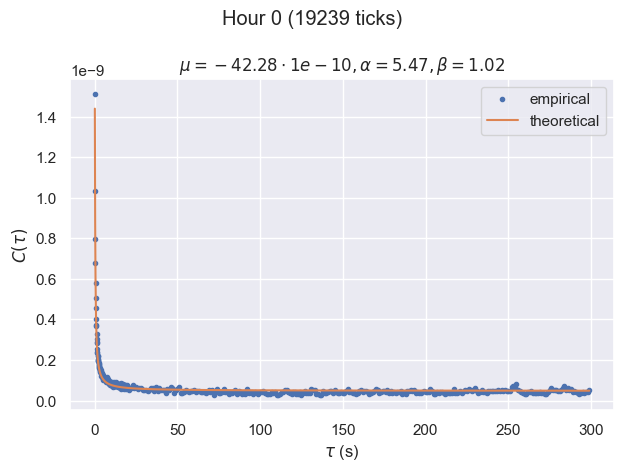

In [14]:
hours = oneday['Hour'].unique()
taus_ms = misc.range_timedelta(100, 20000, 100, 'ms')
taus_s = misc.range_timedelta(20, 60*5, 1, 's')
taus = pd.concat([taus_ms, taus_s])

for hour in hours[:1]:
    onehour = oneday[oneday['Hour'] == hour]
    # ts = pd.Series(onehour['Mid'].values, index=onehour['Timestamp'])
    ts = pd.Series(onehour['Ask'].values, index=onehour['Timestamp'])

    # TODO: compare using Mid/Ask/Bid
    # TODO: we should be using log(price) instead of price

    n_points = len(ts)
    # taus = misc.range_timedelta(100, 20000, 100, 'ms')
    C_emp_values = [misc.C_emp(ts, tau) for tau in taus]
    theta_hat = misc.curve_calibrate(taus, C_emp_values)
    C_th_func = misc.C_th(theta_hat)
    C_th_values = [C_th_func(tau.total_seconds()) for tau in taus]

    plt.figure()
    plt.plot(taus.dt.total_seconds(), C_emp_values, label='empirical', ls='', marker='.')
    plt.plot(taus.dt.total_seconds(), C_th_values, label='theoretical')
    plt.xlabel(r'$\tau$ (s)')
    plt.ylabel(r'$C(\tau)$')
    plt.legend()
    plt.tight_layout()
    plt.suptitle(f'Hour {hour} ({n_points} ticks)')
    plt.title(r'$\mu={:.2f}\cdot1e-10, \alpha={:.2f}, \beta={:.2f}$'.format(1e10*theta_hat[0], theta_hat[1], theta_hat[2]))
    plt.tight_layout()
    plt.show()